# Partisan metrics with ensembles

In our chapter, we conclude that you can't really know if something is intentional gerrymandering without thinking about "what's possible for the state". Ensembles-- large collections of maps meeting the criteria for a valid districting plan for a state-- help us understand this world of possibilities. In this notebook, we use ensembles taken from [another Political Geometry repository](https://github.com/political-geometry/chapter-0-introduction) to look at how partisan metrics vary across many possible maps.

We'll use average district vote share here, since that's the format the data comes in. Heads up: The data loading step will take a long time to run. Prepare yourself!

In [1]:
# Get ourselves some data

%run utilities
%run noninteractive_utilities

import pandas as pd

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
dpi = 300
mpl.rcParams['figure.dpi']= dpi

state = "PA"

# From https://github.com/political-geometry/chapter-0-introduction
filename = "data/chapter-0-ensemble-data/" + state + "/rundata_PRES16.csv"  # Replace with your data location

seat_shares_and_vote_shares = (pd.read_csv(filename)).values
seat_totals = seat_shares_and_vote_shares[:,1]
vote_shares_by_district = 1 - seat_shares_and_vote_shares[:,2:]

democrat_seat_shares = seat_totals/np.shape(vote_shares_by_district)[1]
republican_seat_shares = 1 - democrat_seat_shares


In [2]:
bulk_votes = []
bulk_seats = []
actual_vote_shares = []
actual_seat_shares = []

all_mean_medians = []
all_beta_halves = []

for i in range(np.shape(republican_seat_shares)[0]):
    actual_vote_share = np.mean(vote_shares_by_district[i, :])
    actual_seat_share = republican_seat_shares[i]
    votes, seats = ups_linear(vote_shares_by_district[i, :])
    
    actual_seat_shares.append(actual_seat_share)
    actual_vote_shares.append(actual_vote_share)
    
    bulk_votes.append(votes)
    bulk_seats.append(seats)
    
    mean_median = 0.5 - compute_mean_median_intercept(votes, seats)
    beta_half = compute_partisan_bias_intercept(votes, seats) - 0.5
    all_mean_medians.append(mean_median)
    all_beta_halves.append(beta_half)

    if i % 1000 == 0:
        print(str(100*i/(np.shape(republican_seat_shares)[0])) + "%... ",end='')
    


0.0%... 2.0%... 4.0%... 6.0%... 8.0%... 10.0%... 12.0%... 14.0%... 16.0%... 18.0%... 20.0%... 22.0%... 24.0%... 26.0%... 28.0%... 30.0%... 32.0%... 34.0%... 36.0%... 38.0%... 40.0%... 42.0%... 44.0%... 46.0%... 48.0%... 50.0%... 52.0%... 54.0%... 56.0%... 58.0%... 60.0%... 62.0%... 64.0%... 66.0%... 68.0%... 70.0%... 72.0%... 74.0%... 76.0%... 78.0%... 80.0%... 82.0%... 84.0%... 86.0%... 88.0%... 90.0%... 92.0%... 94.0%... 96.0%... 98.0%... 

# UPS Curves in an ensemble

Let's start by plotting UPS curves for every districting plan in the ensemble. Light magenta curves show the different UPS curves, with more saturated areas indicating more overlap across the plans. The black line shows the average across all UPS curves for each vote share. In Pennsylvania, you can see that the UPS plans in the ensemble generally have a strong bias for Republicans

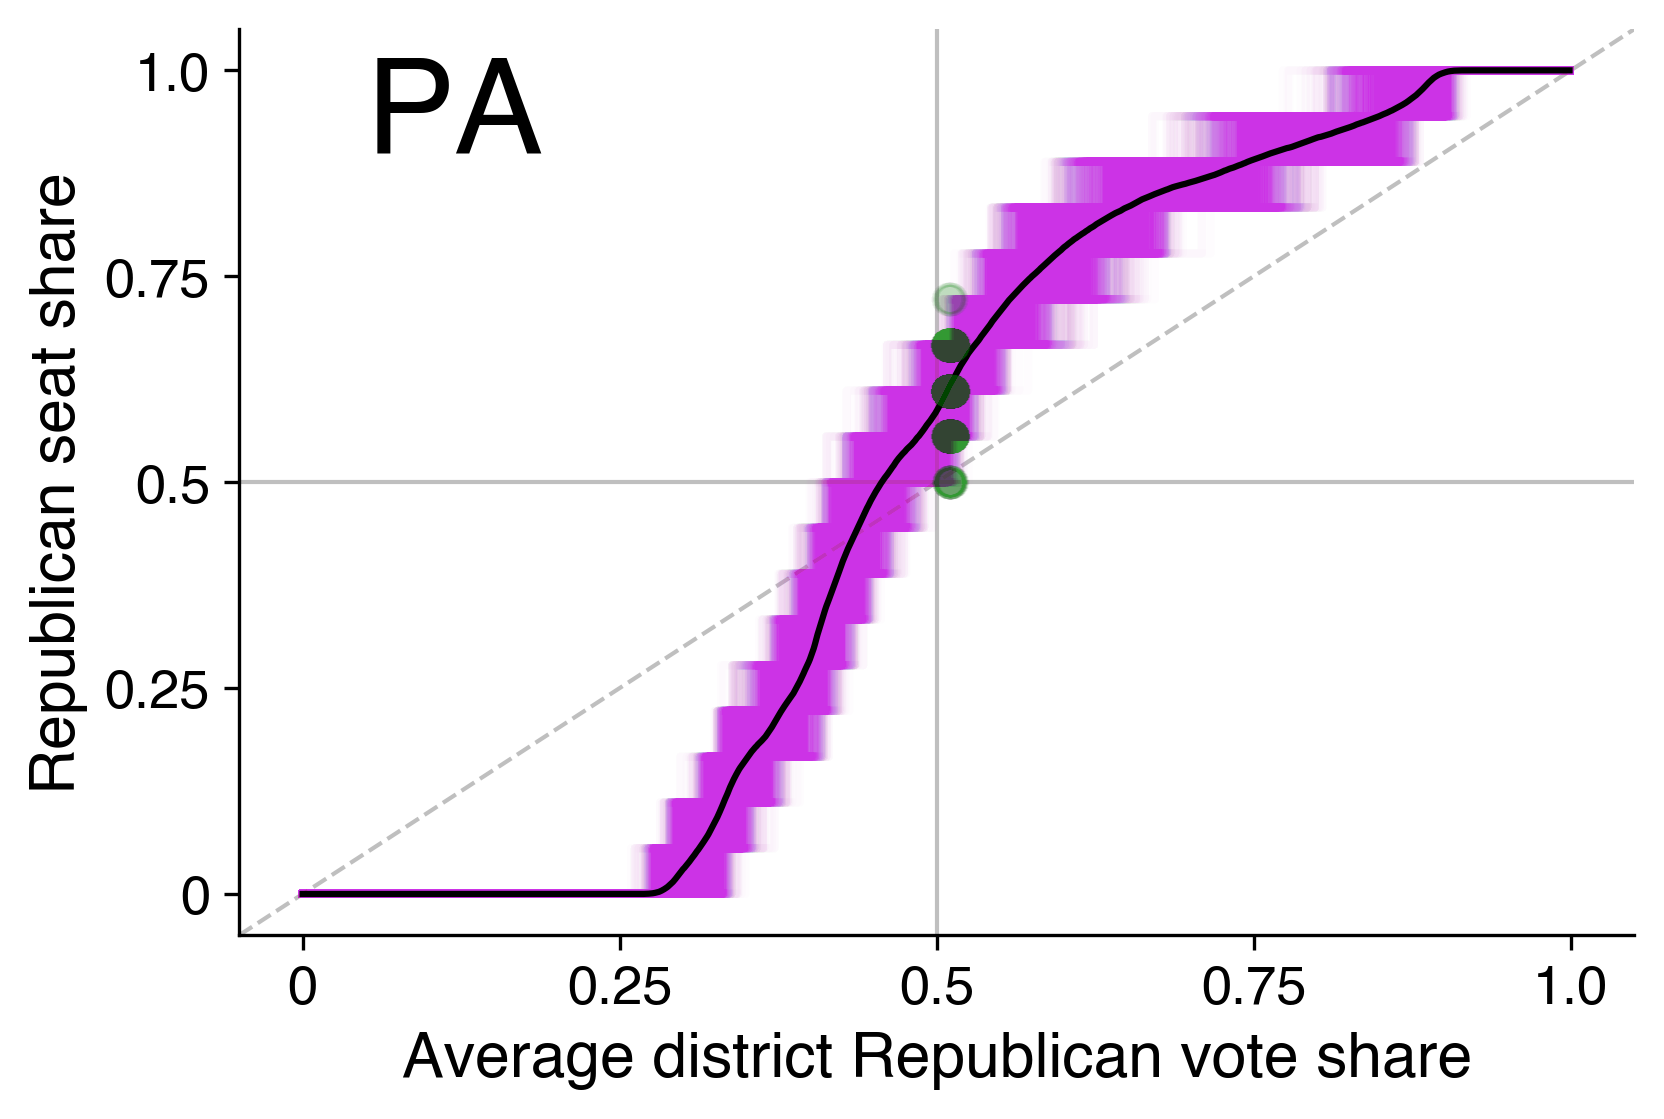

In [3]:
number_of_curves_to_plot = 5000  # Can be increased to 50,000 if your computer can take it
reordering = np.random.permutation(len(actual_vote_shares))
inds = (reordering[:number_of_curves_to_plot]).tolist()

actual_vote_shares_subset = [actual_vote_shares[i] for i in inds]
actual_seat_shares_subset = [actual_seat_shares[i] for i in inds]
votes_subset = [bulk_votes[i] for i in inds]
seats_subset = [bulk_seats[i] for i in inds]


plot_bulk_ups(actual_vote_shares_subset, actual_seat_shares_subset, votes_subset, seats_subset,bulk_votes,bulk_seats, text=state,
                  x_label="Average district Republican vote share")

## Histograms

One of the best ways to understand an ensemble is by looking at the histogram summarizing how many plans occurred at a certain level of a quantity. Below, we'll look at histograms for a number of quantities, including mean-median score, $\beta(0.5)$, seats for Democrat, and seats for Republicans.

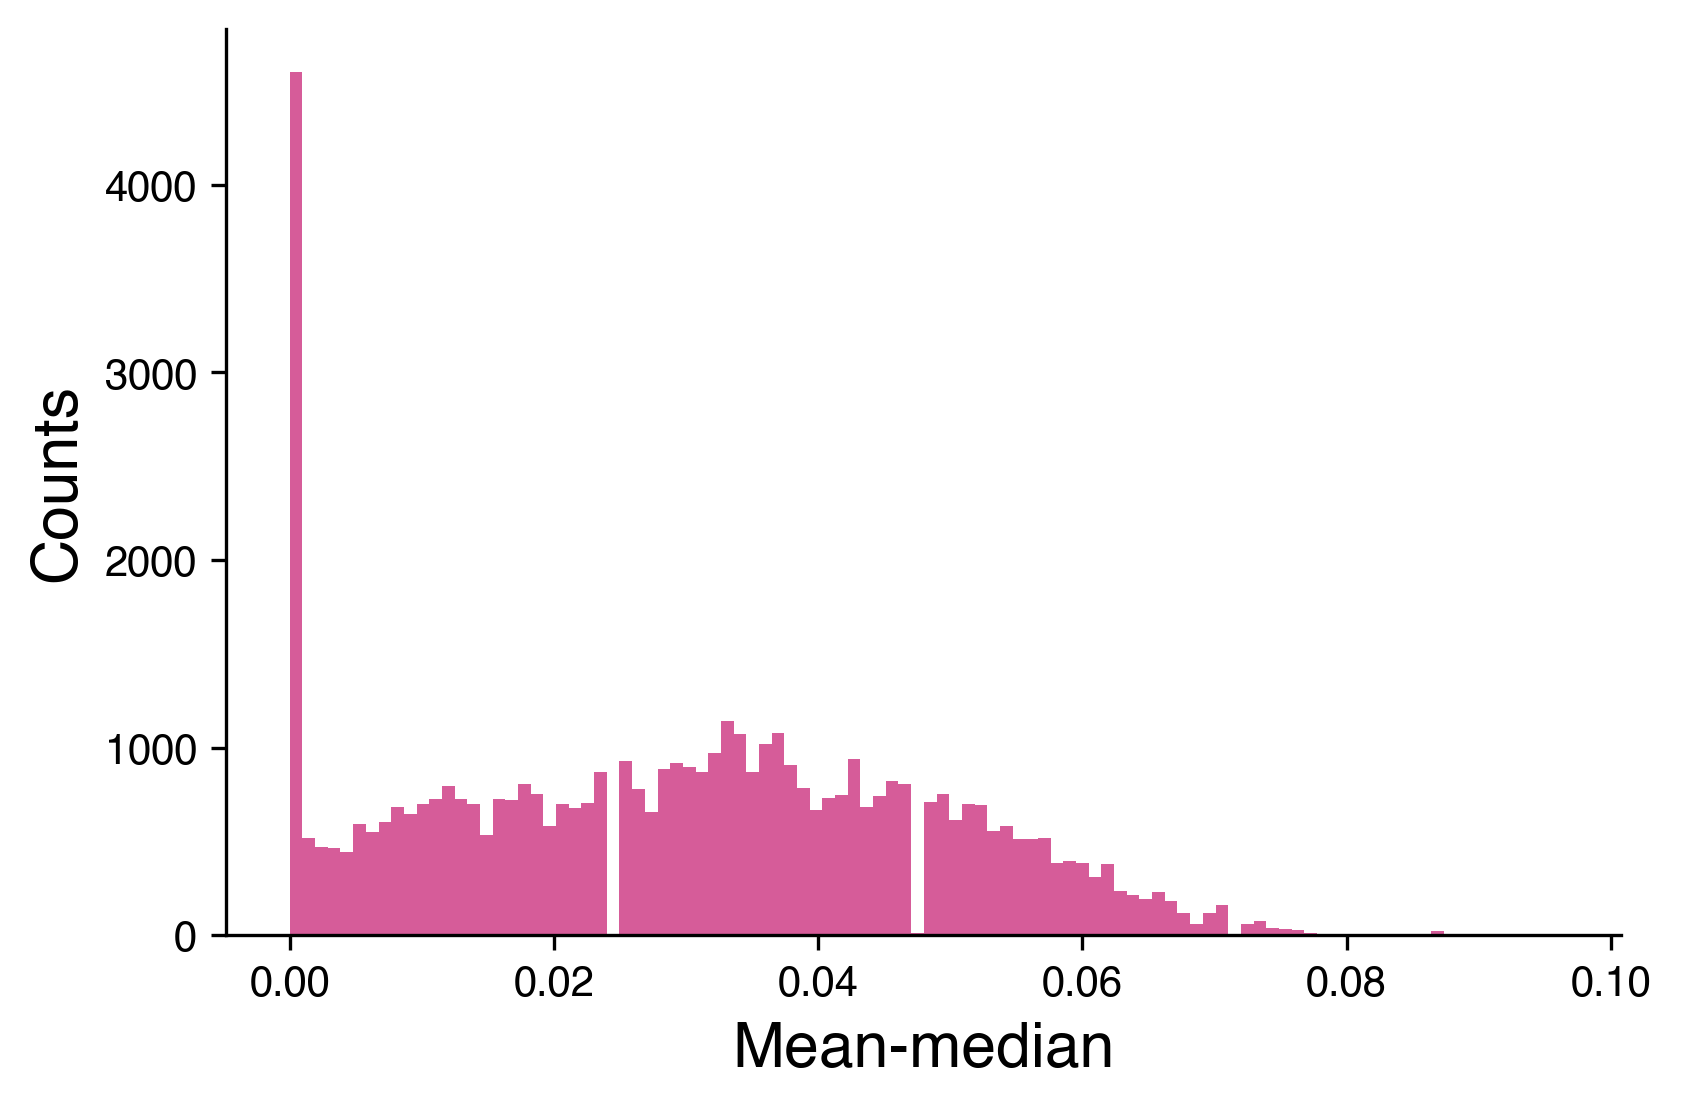

In [4]:
def plot_ensemble_histogram(x, x_label,y_label,seats=False):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    font_name = 'Helvetica'
    font_size = 15
    if seats:
        bins = np.arange(min(x)-1.25,max(x) + 1.5,0.5)
        ax.hist(x,bins=bins,color=[0.8,0.2,0.5,0.8])
        ax.set_xticks(range(int(min(x)),int(max(x)+1)))
    else:
        ax.hist(x,100,color=[0.8,0.2,0.5,0.8])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel(x_label, fontname=font_name, fontsize=font_size)
    ax.set_ylabel(y_label, fontname=font_name, fontsize=font_size)


plot_ensemble_histogram(all_mean_medians, "Mean-median", "Counts")


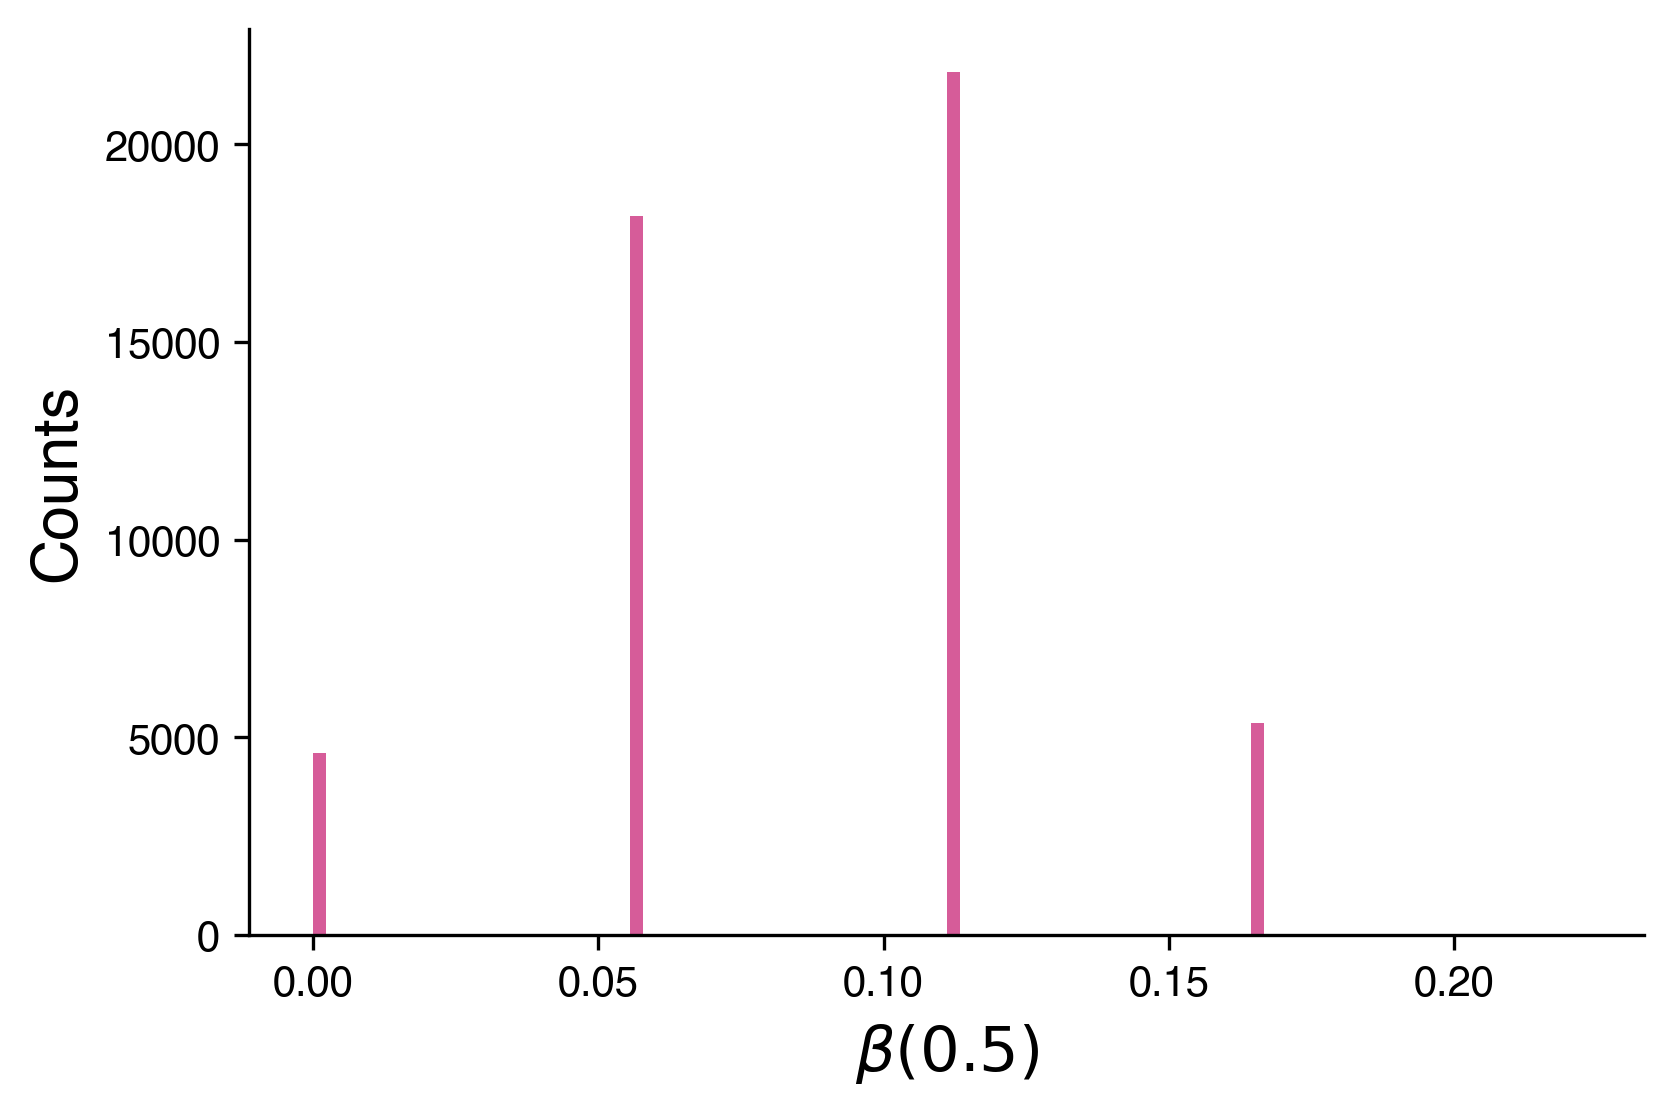

In [5]:
plot_ensemble_histogram(all_beta_halves,
                        "$\\beta(0.5)$", 
                        "Counts")

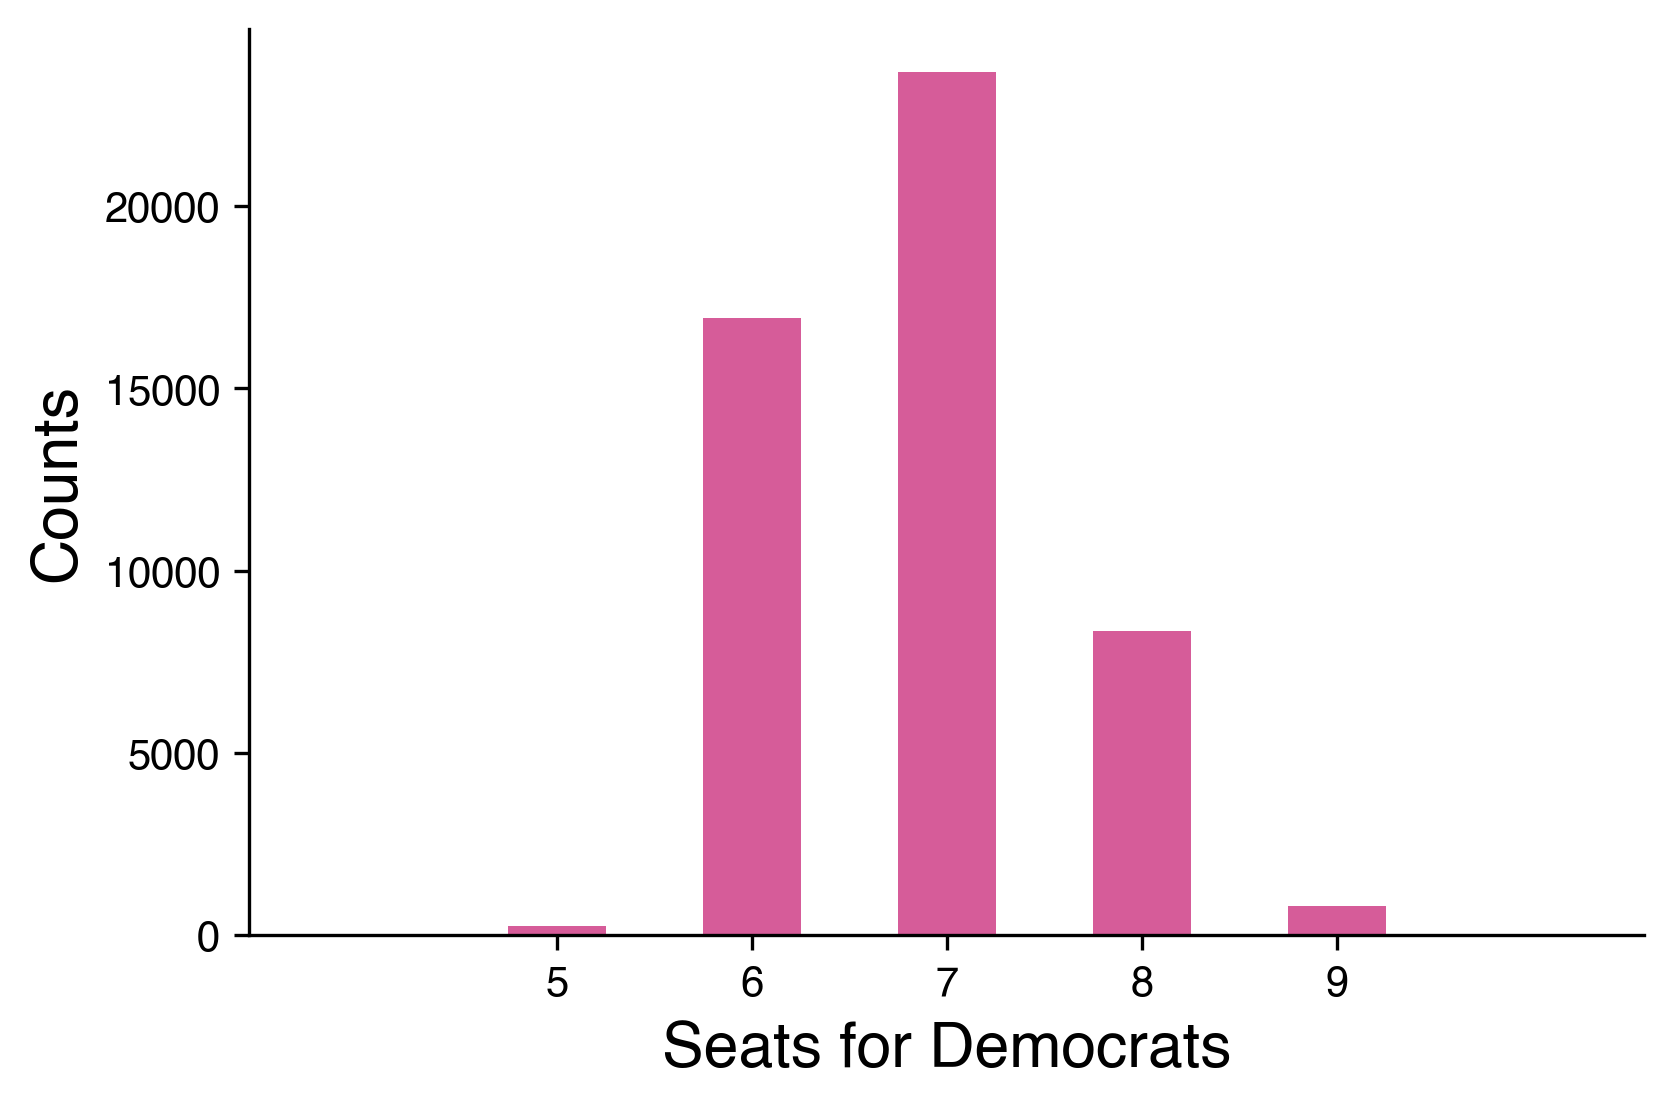

In [6]:
plot_ensemble_histogram(seat_totals,
                        "Seats for Democrats",
                        "Counts",
                        seats=True)

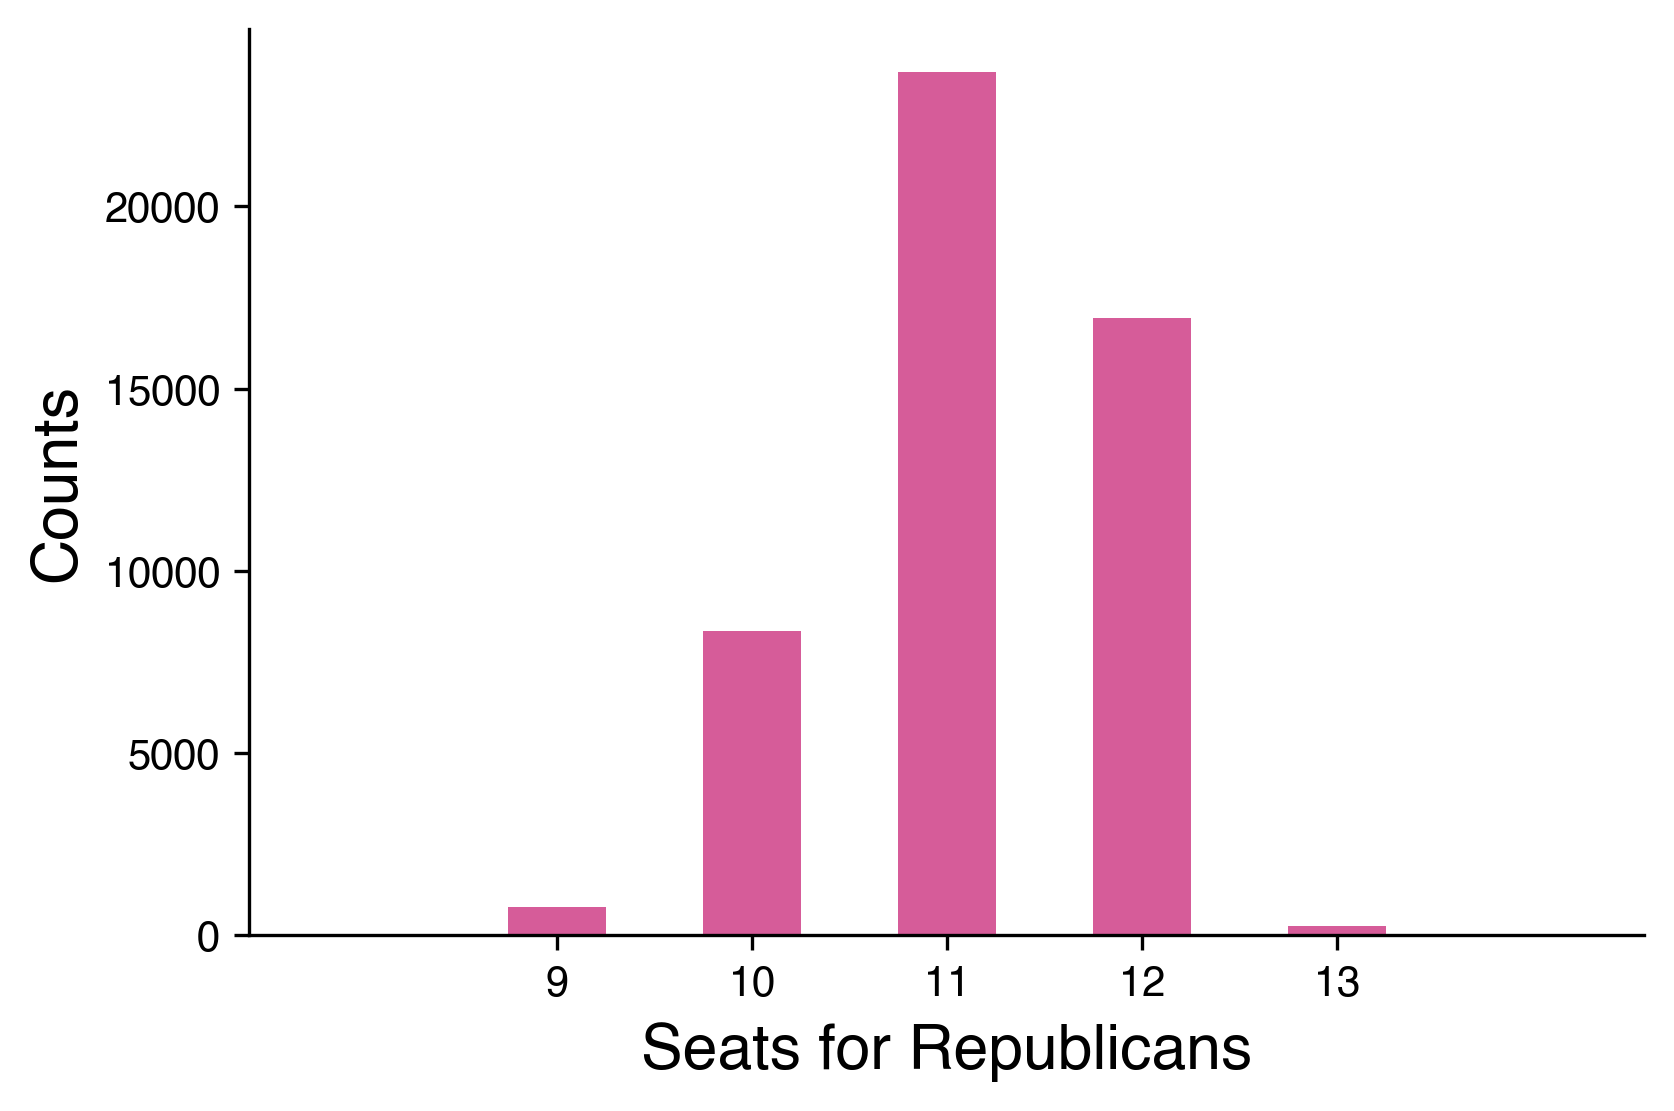

In [7]:
plot_ensemble_histogram(np.shape(vote_shares_by_district)[1] - seat_totals,
                        "Seats for Republicans",
                        "Counts",
                        seats=True)

# Adding a little swing

Let's run a hypothetical example. What happens if we swing the Republican vote share by -0.5%, so our state gets half a percentage point more blue? If we do this, and then plot the histogram of Republican seat shares, we can see that, for Pennsylvania in 2016 at least, the story is largely unchanged. But that small amount of swing is enough to take the statewide voteshare for Democrats from a minority to a majority for that year. In other words, Democrats could have had a statewide majority and still had the odds stacked against them across tens of thousands of reasonable plans. 

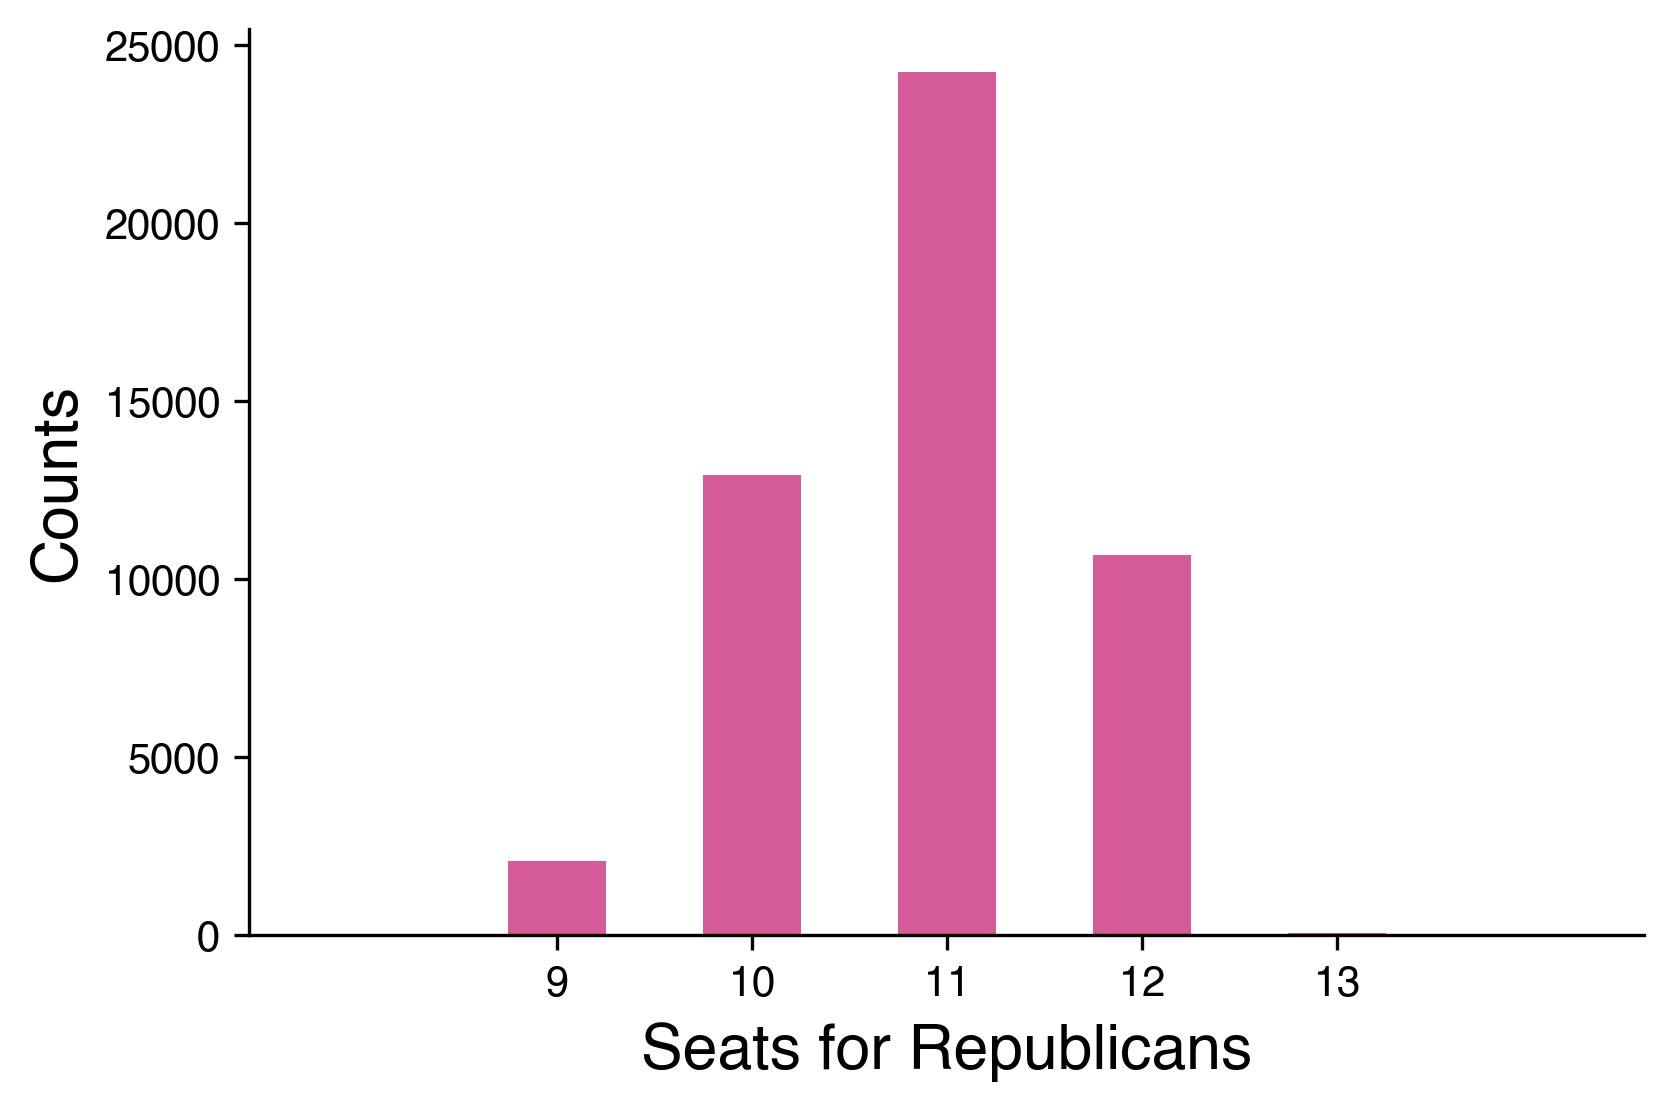

In [8]:
seats_for_republicans = []

for i in range(np.shape(republican_seat_shares)[0]):
    run = vote_shares_by_district[i, :]
    ups_swing = -0.005
    new_run = run + ups_swing
    seats_for_republicans.append(len(new_run[new_run >= 0.5]))
    
plot_ensemble_histogram(seats_for_republicans,"Seats for Republicans", "Counts",seats=True)


## Differences in margin

We can define _differential packing_, or $d$, to be difference between "the average margin Democrats win by in districts Democrats win" and "the average margin that Republicans win by in the districts Republicans win". This gives us an idea of how packing at the district level is affecting the outcomes across the state. 

A positive $d$ means Democrats are winning their districts by larger margins on average, versus Republicans. (When Democrats and Republicans win the same number of seats in a state, this is the same as the efficiency gap.) 

In the Pennsylvania ensembles, the average differential packing is approximately 0.4, highlighting how Democrats are winning with larger margins than Republicans are.

0.04442480316066984

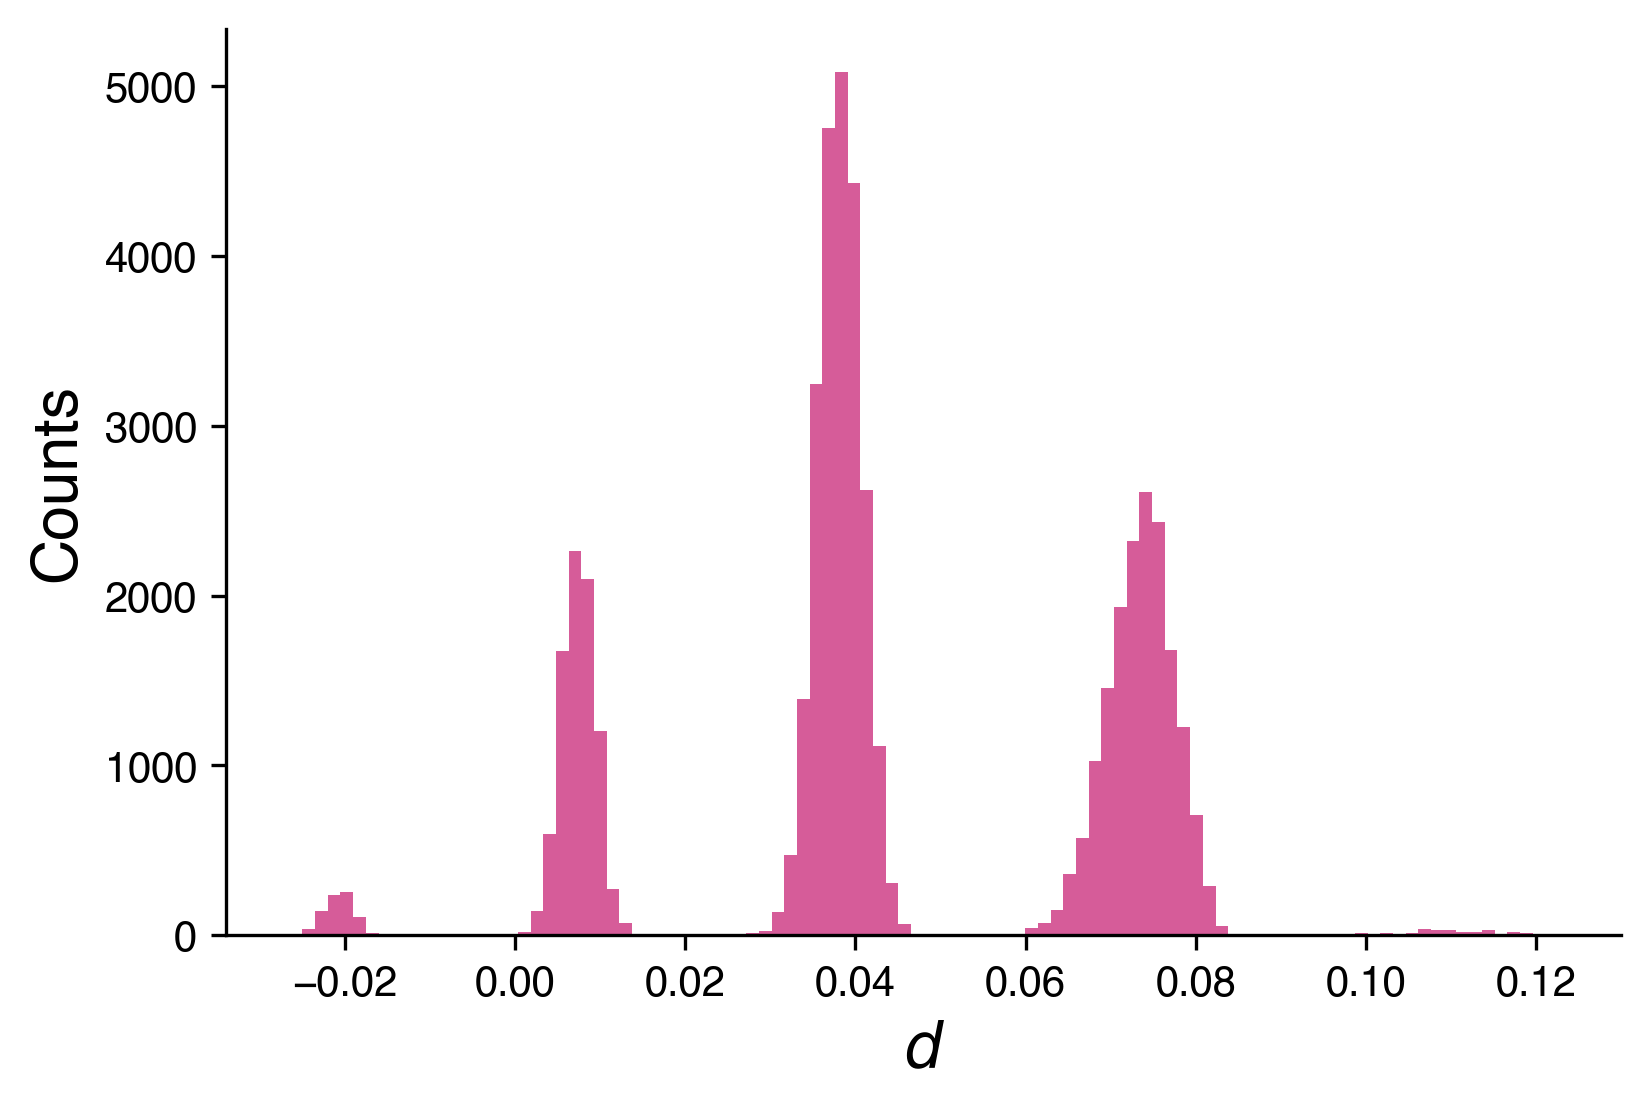

In [9]:
all_deltas = []

for i in range(np.shape(vote_shares_by_district)[0]):
    republican_vote_shares_by_district = vote_shares_by_district[i,:]
    republican_won_districts = republican_vote_shares_by_district[republican_vote_shares_by_district >= 0.5]
    democrat_won_districts = republican_vote_shares_by_district[republican_vote_shares_by_district < 0.5]
    average_republican_margin = np.mean(republican_won_districts - 0.5)
    average_democrat_margin = np.mean(0.5 - democrat_won_districts)
    
    delta = average_democrat_margin - average_republican_margin
    all_deltas.append(delta)
    

plot_ensemble_histogram(all_deltas, "$d$", "Counts",)

all_deltas = np.array(all_deltas)
np.mean(all_deltas)